# League of Legends Game Result Prediction

Authors: Victor Wang hanmingw@andrew.cmu.edu & Ryan Wang zhenxiw@andrew.cmu.edu

### Table of Contens  

- Introduction
    - [Summary](#Summary)
    - [League of Legends Rank System ](#League-of-Legends-Rank-System)
    - [LoL Challenger](#LoL-Challenger) 
    
    
    
- [Data Scraping](#Data-Scraping)
    - [Import Libraries](#Import-Libraries)
    - [Summoner Names](#Getting-Summoner-Names)
    - [Match Hisotry](#Scraping-Match-History-for-each-player)
    - [Data Description](#Data-Description)
    - [Data Dictionary](#Data-Dictionary)  
    
    
    
- [Data Processing](#Data-Processing) 
    - [Handling Imbalanced Data](#Check-for-Imbalanced-Data)
    - [Feature Correlation](#Feature-Correlation-Heat-Map)
    - [Encoding](#Data-Encoding)


- [Machine Learning Models](#Machine-Learning-Models) 
    - [Logistic Regression](#Model-1:-Logistic-Regression:-(*L2*-penalizer))
    - [SVM](#Model-2:-SVM-Model)
    - [Random Forest](#Model-3:-Random-Forest)
    - [Multi-layer Perceptron](#Model-4:-Multilayer-Perceptron)
    - [Result](#Result)
    

- [Top Features](#Top-Feature-Analysis)
    - [Top Champions](#Top-Champions)
        - [Champion Suggestions & Insights](#Champion-Suggestions-and-Insights)
    - [Top Features](#Top-Features)
        - [Gameplay Suggestions](#Gameplay-Suggestions) 
    
    
- [Conculsion](#Conclusion)
    - [Improvement & Further Steps](#Improvement-&-Further-Steps)

### Summary

League of Legens is a multiplayer oneline battle video game. It became extremely popular in the recent years and is famous of its revolutionary concepts about e-sports competitions amont the young generations. Similar to other sports such as basketball, people often times are very interested in making game result prediction for such complex strategic games based on various factors. 

In this project we are going to build up a data science pipeline to predict game results for Leauge of Legdends 5v5 solo rank games using Machine Learning algorithms to help LoL players imporve their gaming performances.

### League of Legends Rank System  
There are nine ranks that currently exist in League of Legends. Each rank is represented by a specific name and icon. This way LoL players are able to differentiate their skill level with ease since those in the same rank and tier should have similar proficiency in LoL.  
These are the nine ranks that currently exist in League of Legends:
   - Iron 
   - Bronze
   - Silver
   - Gold
   - Platinum
   - Diamond
   - Master
   - Grandmaster
   - Challenger 

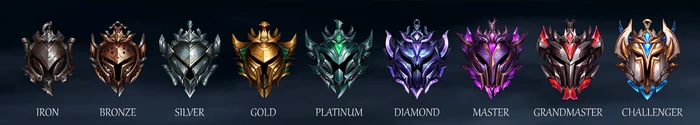

In [14]:
from IPython.display import Image
Image('League_Tiers_2019.png') # reference: https://earlygame.com/lol/ranking-system

### LoL Challenger  
Challenger is the highest rank in League of Legends and represents the top 300 players of each region. To achieve Challenger rank, players will have to make it through the eight previous LoL tiers.  

Our project targets all the challengers players from the `North America` region and the `South Korea` region since there are over 150 million registered users in the world, and it would be inefficient to do a massive computation for all 150 million players. The North America region and the South Korea region are two of the most representative servers across all regions in the world, and challenger players are good representatives of the LoL community. We take a total of 600 challengers from these two servers for our predcitin model. 

## Data Scraping

### Import Libraries

In [3]:
from bs4 import BeautifulSoup
import requests
import json
import sys
import cassiopeia as cass # need to install cassiopeia
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
from riotwatcher import LolWatcher, ApiError # need to install riowatcher

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

### Getting Summoner Names

First, in order to scrape all challenger players from North America and South Korean, we need to sign up for a API key from `Riot Developer Portal` https://developer.riotgames.com/. After installing `Cassiopeia`, we can get all summoner names of all challenger players in NA and KR region. 

In [26]:
APIKey = 'RGAPI-0116ac63-7c46-46db-bc10-d380ce6ec852'
cass.set_riot_api_key(APIKey)

NA_challenger_league = cass.get_challenger_league(queue=cass.Queue.ranked_solo_fives, region = 'NA')
KR_challenger_league = cass.get_challenger_league(queue=cass.Queue.ranked_solo_fives, region = 'KR')

num_na_challenger_players = len(NA_challenger_league)
num_kr_challenger_players = len(KR_challenger_league)

NA_challenger_players = [NA_challenger_league[i].summoner.name for i in range(num_na_challenger_players)]
KR_challenger_players = [KR_challenger_league[i].summoner.name for i in range(num_kr_challenger_players)]

print('The number of challenger players in NA is: {}'.format(num_na_challenger_players))
print('The number of challenger players in KR is: {}'.format(num_kr_challenger_players))

The number of challenger players in NA is: 300
The number of challenger players in KR is: 300


### Scraping Match History for each player

To get each player's match history information, we define a function `get_past_matches` to scrape 5v5 ranked solo match history for individual players from `Mobalytics.gg` by each player's ' `summoner name` we scraped above and `region` the player belongs to. We also inclue a parameter `top` to get the number of most recent match history we want to explore.  
Reference: https://app.mobalytics.gg/lol

In [16]:
def get_past_matches(summonerName: str, region: str, top: int):

    url = "https://app.mobalytics.gg/api/lol/graphql/v1/query"
    payload = json.dumps(
        {
            "operationName": "LolProfilePageMoreMatchesQuery",
            "variables": {
                "withMatchParticipantDetailed": False,
                "summonerName": summonerName,
                "region": region,
                "top": top,
                "skip": 0,
                "queue": "RANKED_SOLO",
                "rolename": None,
            },
            "extensions": {
                "persistedQuery": {
                    "version": 1,
                    "sha256Hash": "92fe7bcd15126c52548a71e98d1e16c6fd128692631c73a9b512ea62f072156c",
                }
            },
        }
    )
    headers = {"Content-Type": "application/json"}
    try:
        response = requests.request("POST", url, headers=headers, data=payload)
        games_list = response.json()["data"]["lol"]["player"]["matchesHistory"][
            "matches"
        ]
        return games_list
    except:
        return None

Using function `get_past_matches` defined above, we scrape most 20 mathes of each challenger player in NA and KR regions. We get a total of `600 * 20 = 12000` samples.

In [68]:
all_match_history = {}

for player in NA_challenger_players:
    all_match_history[player] = (get_past_matches(player, 'NA', 20))
    
    
for player in KR_challenger_players:
    all_match_history[player] = (get_past_matches(player, 'KR', 20))

### Data Description



The following table is a description of the features we can generate from players' match history for our game data analysis:

Feature | Description
:---|:---
`summonerName`| name that will be known by in game
`region`| region that this player belongs to, here we have NA for North America and KR for South Korea
`winRate`| win percentage of this player calculated from his/her pevious matches
`hotStreak`| True if this player won the previous game, Flase if this player lost the previous game
`team`| the team that this player is on in this game (Blue/Red)
`role`| the position that this player played in this game (ADC/Support/Mid/Jungle/Top)
`cs`| the number of minions, monsters, and other things (such as wards) that this player has killed
`csDiiff10`| the number of creep score difference every 10 minute 
`kp`| the ratio of kill participation in percentage
`mvpScore`| the mostvaluable score for this player in the game
`controlWardsPlaced`| the number of control wards placed of this player in the game
`sightWardsPlaced`| the number of sight wards placed of this player in the game
`kills` |the number of enemy killed of this player in the game
`deaths`| the number of deaths of this player in the game
`assists`| the number of assists of this player in the game
`result`| result of the game (WON/LOST)

### Data Dictionary  

We first build a data dictionary with all the features as keys and leave the values empty.

In [123]:
data = {
    'summonerName': [],
    'region': [],
    'winRate': [],
    'hotStreak': [],
    'championId': [],
#     'Champion':[],
    'team': [],
    'role': [],
    'cs': [],
    'csDiff10': [],
    'kp': [],
    'mvpScore': [],
    'controlWardsPlaced': [],
    'sightWardsPlaced': [],
#     'kills': [],
#     'deaths': [],
#     'assists': [],
    'kda': [],
    'result': []
}

After scraping match history for each player, we extrat corresponding data into our data dictionary built above. Since a few players' match history are missing, we take out these players and get match infomration for the rest of the players.

In [124]:
unfecthable_players = []
# unfecthable_players.append('Paddy PimbIett')
unfecthable_players.append('푸크라데스')
# unfecthable_players.append('Esperance')
unfecthable_players.append('Sayuikiki')
for name in all_match_history.keys():
    if all_match_history[name] is None:
        unfecthable_players.append(name)
        print(name)
        continue
    for match in all_match_history[name]:
        if name not in unfecthable_players:
            data['summonerName'].append(name)
            data['region'].append(match['subject']['region'])
            data['championId'].append(match['subject']['championId'])
            data['team'].append(match['subject']['team'])
            data['role'].append(match['subject']['role'])
            data['cs'].append(match['subject']['cs'])
            data['csDiff10'].append(match['subject']['csDiff10'])
            data['mvpScore'].append(match['subject']['mvpScore'])
            data['kp'].append(np.round(match['subject']['kp'],2))
            data['controlWardsPlaced'].append(match['subject']['controlWardsPlaced'])
            data['sightWardsPlaced'].append(match['subject']['sightWardsPlaced'])
    #         data['kills'].append(match['subject']['kda']['k'])
    #         data['deaths'].append(match['subject']['kda']['d'])
    #         data['assists'].append(match['subject']['kda']['a'])

            if match['subject']['kda']['d'] == 0:
                data['kda'].append(np.round(match['subject']['kda']['k'] + match['subject']['kda']['a'],2))
            else:
                data['kda'].append(np.round((match['subject']['kda']['k'] + match['subject']['kda']['a']) / match['subject']['kda']['d'],2 ))

            has_team = False
            for team in match['teams']:
                if team['id'] == match['subject']['team']:
                    has_team = True
                    data['result'].append(team['result'])
            if not has_team:
                data['result'].append("NA")

unfecthable_players

waste it on me
byz
실 망
Lc7
노 르


['푸크라데스', 'Sayuikiki', 'waste it on me', 'byz', '실 망', 'Lc7', '노 르']

We are still missing players' `hotStreak` and `winRate` information. We will scrape these two features from `LoLWatcher` imported from `RiotWachter` using the API key we signed up from Riot Developer Portal. RiotWatcher is a thin wrapper on top of the Riot Games API for League of Legends.  
Reference: https://riot-watcher.readthedocs.io/en/latest/

In [75]:
lol_watcher = LolWatcher(APIKey)
player_stats = []

for player in NA_challenger_players:
    if player not in unfecthable_players:
        player = lol_watcher.summoner.by_name('na1', player)
        player_stats.append(lol_watcher.league.by_summoner('na1', player['id']))        

In [78]:
for player in KR_challenger_players:
    if player not in unfecthable_players:
        player = lol_watcher.summoner.by_name('kr', player)
        player_stats.append(lol_watcher.league.by_summoner('kr', player['id']))

After scraping `hotStreak` and `winRate`, we also store them into our data dictionary.

In [118]:
player_hotStreak = []
player_winRate = []
for stats in player_stats:
    if len(stats) == 0:
        player_hotStreak.append('NA')
        player_winRate.append('NA')
    else:
        player_hotStreak.append(stats[0]['hotStreak'])
        winrate = np.round(stats[0]['wins'] / (stats[0]['wins'] + stats[0]['losses']), 2)
        player_winRate.append(winrate)
      

In [126]:
data['winRate'] = np.repeat(player_winRate, 20)
data['hotStreak'] = np.repeat(player_hotStreak, 20)

Beyond `championId` we extracted above from `Mobalytics`, we also want to get the name of champion that each `championId` corresponds to. 

In [120]:
champ_dic = {266: 'Aatrox', 103: 'Ahri', 84:'Akali', 166:'Akshan', 12:'Alista',
      32:'Amumu', 34:'Anivia', 1:'Annie',523:'Aphelios',22:'Ashe',
      136:'Aurelion Sol',268:'Azie',432:'Bard',53:'Blizcrank',
      63:'Brand',201:'Braum',51:'Caitlyn',164:'Camille',69:'Cassiopeia',
      31:'Cho Gath', 42:'Corki', 122:'Darius', 131:'Diana', 119:'Draven',
      36:'Dr.Mundo', 245:'Ekko',60:'Elise', 28:'Evelynn', 81:'Ezreal',
      9:'Fiddlesticks', 114:'Fiora', 105:'Fizz', 3:'Galio', 41:'Gangplank',
      86:'Garen', 150:'Ganr',79:'Gragas', 104:'Graves', 887:'Gwen',
      120:'Hecarim', 74:'Heimerdinger', 420:'Illaoi',39:'Irelia',427:'Ivern',
      40:'Jana', 59:'Jarvan IV', 24:'Jax',126:'Jayce', 202:'Jhin', 222:'Jinx',
      145:'Kaisa',429:'Kalista',43:'Karma',30:'Karthus',38:'Kassadin',
      55:'Katrina', 10:'Kayle', 141:'Kayn', 85:'Kennen', 121:'KhaZix',
      203:'Kindred',240:'Kled',96:'Kog Maw',7:'LeBlanc',64:'Lee Sin', 
      89:'Leona', 876:'Lillia', 127:'Lissandra',236:'Lucian', 117:'Lulu',
      99:'Lux',54:'Malphite',90:'Malzahar',57:'Maokai',11:'Master Yi',
      21:'Miss Fortune',62:'Wukong',82:'Mordkaiser',25:'Morgana',267:'Nami',
      75:'Nasus',111:'Nautilus',518:'Neeko',76:'Nidalee',56:'Nocturne',
      20:'Nunu & Willump', 2:'Oalf',61:'Orianna',516:'Ornn',80:'Pantheon',
      78:'Poppy',555:'Pyke',246:'Qiyana',133:'Quinn',497:'Rakan',
      33:'Rammus',421:'Rek Sai',526:'Rell',888:'Renata Glasc',58:'Renekton',
      107:'Rengar',92:'Riven',68:'Rumble',13:'Ryze',360:'Samira',113:'Sejuani',
      235:'Senna',147:'Sraphine',875:'Sett',35:'Shaco',98:'Shen',102:'Shvana',
      27:'Singed',14:'Sion',15:'Sivir',72:'Skarner',37:'Sona',16:'Soraka',
      50:'Swain',517:'Sylas',134:'Synra',223:'Tahm kench',163:'Taliyah',
      91:'Talon', 44:'Taric',17:'Teemo',412:'Thresh',18:'Tristana',48:'Trundle',
      23:'Tryndamere',4:'Twisted Fate', 29:'Twitch', 77:'Udyr', 6:'Urgor',
      110:'Varus',67:'Vayne',45:'Veigar',161:'Vel Koz',711:'Vex',254:'Vi',
      234:'Viego',112:'Viktor',8:'Vladmir',106:'Volibear',19:'Warick',498:'Xayah',
      101:'Xerath', 5:'Xin Zhao', 157:'Yasuo', 777:'Yone', 83:'Yorick',350:'Yummi',
      154:'Zac',238:'Zed',221:'Zeri',115:'Ziggs',26:'Zilean',142:'Zoe',143:'Zyra'}

After getting the names of champions, we store them into our data dictionary.

Now, we have all the features we want and the data corresponding to each feature. We display our data with pandas DataFrame,  and we have a total of 11860 samples with 16 features for each sample. 

In [159]:
data['Champion'] = [champ_dic.get(champ, champ) for champ in df['championId']]
df = pd.DataFrame(data=data)

fifth_col = df.pop('Champion')
df.insert(5, 'Champion', fifth_col)
df

,summonerName,region,winRate,hotStreak,championId,Champion,team,role,cs,csDiff10,kp,mvpScore,controlWardsPlaced,sightWardsPlaced,kda,result
0,lts a process,NA,0.52,False,111,Nautilus,RED,SUPPORT,36,14,57.69,3,1,15,7.50,WON
1,lts a process,NA,0.52,False,117,Lulu,RED,SUPPORT,17,-10,50.00,4,3,35,5.00,WON
2,lts a process,NA,0.52,False,117,Lulu,BLUE,SUPPORT,7,-2,38.46,9,0,17,0.83,LOST
3,lts a process,NA,0.52,False,117,Lulu,RED,SUPPORT,8,-6,50.00,3,1,15,6.00,WON
4,lts a process,NA,0.52,False,117,Lulu,BLUE,SUPPORT,9,3,62.50,4,4,17,3.75,WON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11855,langman de,KR,0.60,False,80,Pantheon,RED,SUPPORT,82,13,61.54,2,15,39,3.43,WON
11856,langman de,KR,0.60,False,119,Draven,RED,ADC,204,5,50.00,7,3,5,1.70,LOST
11857,langman de,KR,0.60,False,81,Ezreal,RED,ADC,163,-32,34.38,7,3,4,1.83,WON
11858,langman de,KR,0.60,False,236,Lucian,BLUE,ADC,194,8,38.89,10,0,5,1.17,LOST


Saving our dataframe into a csv file for convinence. 

In [99]:
df = pd.read_csv('LOL Data')
df['region'] = df['region'].fillna('NA')
df

,summonerName,region,winRate,hotStreak,championId,Champion,team,role,cs,csDiff10,kp,mvpScore,controlWardsPlaced,sightWardsPlaced,kda,result
0,lts a process,NA,0.52,False,111,Nautilus,RED,SUPPORT,36,14,57.69,3,1,15,7.50,WON
1,lts a process,NA,0.52,False,117,Lulu,RED,SUPPORT,17,-10,50.00,4,3,35,5.00,WON
2,lts a process,NA,0.52,False,117,Lulu,BLUE,SUPPORT,7,-2,38.46,9,0,17,0.83,LOST
3,lts a process,NA,0.52,False,117,Lulu,RED,SUPPORT,8,-6,50.00,3,1,15,6.00,WON
4,lts a process,NA,0.52,False,117,Lulu,BLUE,SUPPORT,9,3,62.50,4,4,17,3.75,WON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11855,langman de,KR,0.60,False,80,Pantheon,RED,SUPPORT,82,13,61.54,2,15,39,3.43,WON
11856,langman de,KR,0.60,False,119,Draven,RED,ADC,204,5,50.00,7,3,5,1.70,LOST
11857,langman de,KR,0.60,False,81,Ezreal,RED,ADC,163,-32,34.38,7,3,4,1.83,WON
11858,langman de,KR,0.60,False,236,Lucian,BLUE,ADC,194,8,38.89,10,0,5,1.17,LOST


## Data Processing

### Check for Imbalanced Data  
Imbalanced data mean that the number of observations differ for the classes in a classification dataset. In machine learning, this imbalance can lead to inaccurate results. Therefore, we want to check whether our dataset is imbalanced or not to eliminate potential data bias.

For our project, we want to check if the number of games won/lost are approximately evenly distributed and if the number of teams in BLUE/red are approximately evenly distributed.

Based on the pie charts below, we can see that about 55% of the samples from our dataset won the game, and about 45% of the samples form our dataset lost the game. About 52% of the samples are from team RED, and about 48% of the samples are from team BLUE. This is well-distributed data since the classes are all clost to 50% each, and there is no action needed for handling imbalance data.

<AxesSubplot:title={'center':'Team Distribution'}, ylabel='team'>

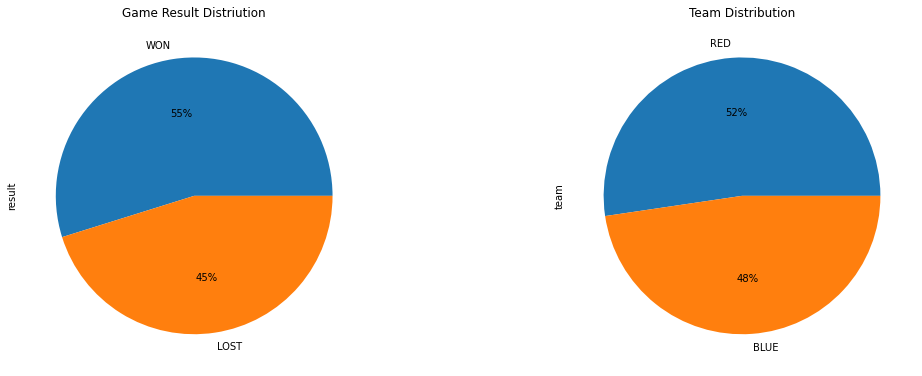

In [63]:
fig = plt.figure(figsize=(18,14))

ax1 = plt.subplot2grid((2,2),(0,0))
plt.title('Game Result Distriution')
df['result'].value_counts().plot.pie(autopct='%1.f%%')

ax2 = plt.subplot2grid((2,2),(0,1))
plt.title('Team Distribution')
df['team'].value_counts().plot.pie(autopct='%1.f%%')

Since there are five different roles in games of LoL, we also want to check whether these five roles are well-distributed across our samples. 

As shown in the pie char below, the five roles are approximately evenly distributed, each role has about 20% ratio in the entire sample, and we do not need no handle imbalance data.

<AxesSubplot:title={'center':'Role Distribution'}, ylabel='role'>

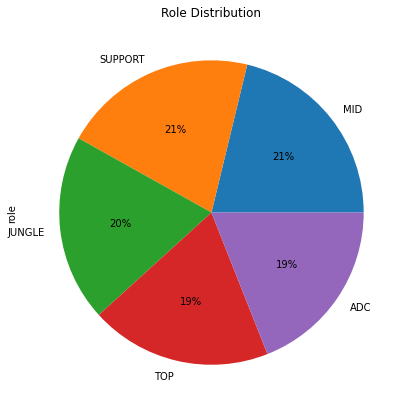

In [70]:
fig = plt.figure(figsize=(10,7))
plt.title('Role Distribution')
df['role'].value_counts().plot.pie(autopct='%1.f%%')

#### Feature Correlation Heat Map

In machine learning, we need to be aware of multicollinearity which occurs when two or more independent varaibles are highly correlated with one another. This means that an independent variable can be predicted from another independent variable. Multicollinearity may affect the accuracy of our model and we might lost reliability in determining the effects of individual independent features on the dependent feature.

To check for multicollinearity, we plot a heatmap among all the features to learn their correlation with one another.

Text(0.5, 1.0, 'HeatMap for Features Correlation')

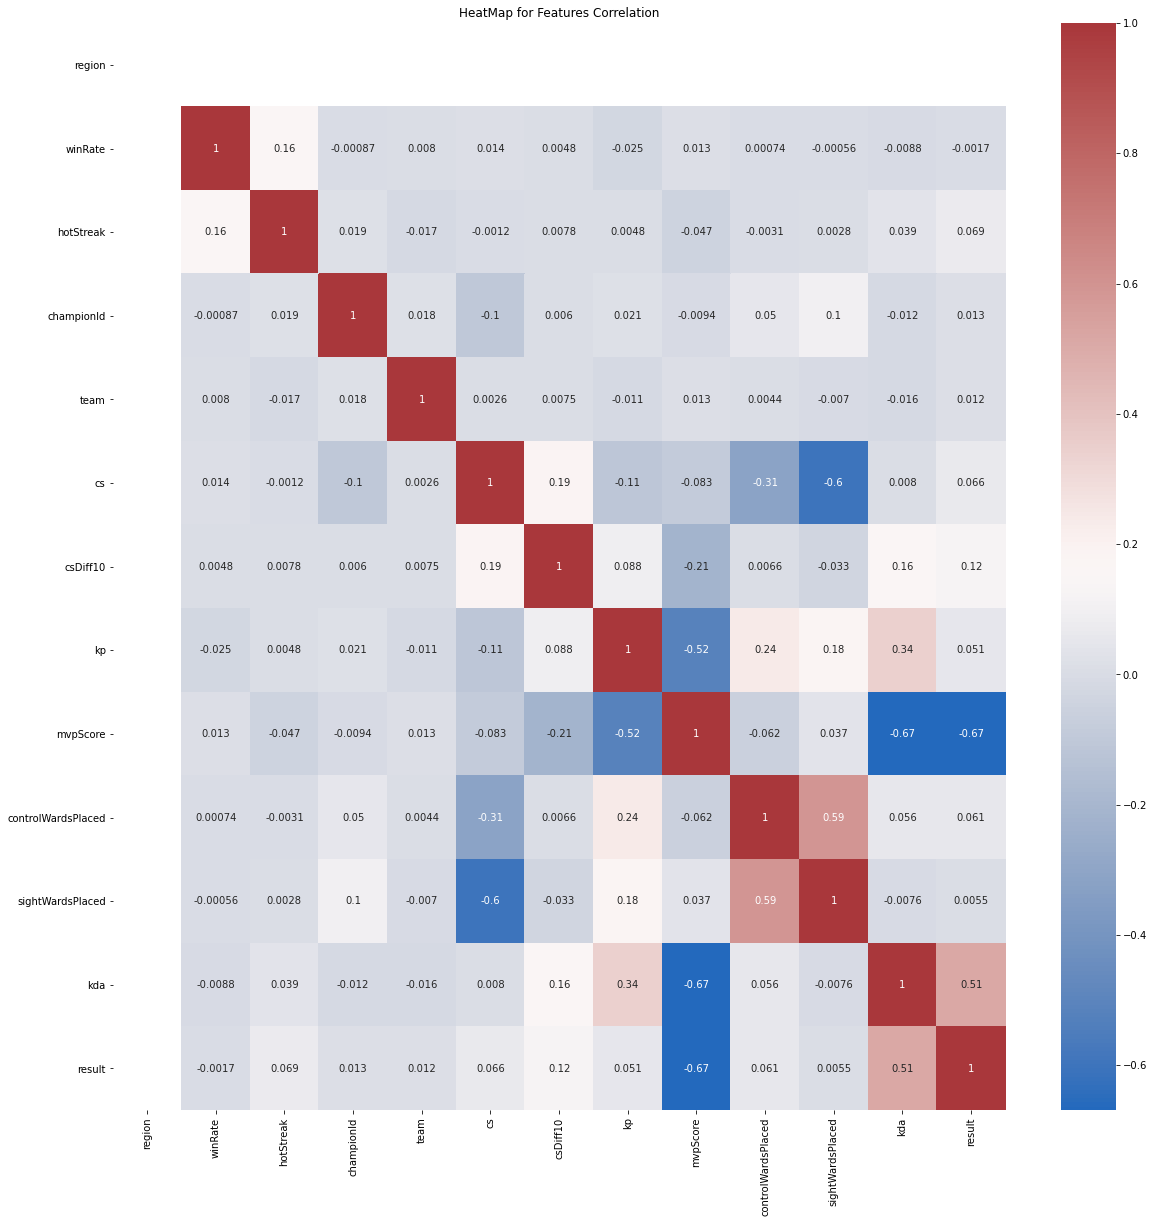

In [81]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='vlag', annot=True)
plt.title('HeatMap for Features Correlation')

After reviewing the heatmap above, we can see that feature `mvpScore` has high correaltion with features `kda` and `result`. Therefore, we are going to drop `mvpScore` for our later machine learning models

In [64]:
df = df.drop('mvpScore', 1)
df

,summonerName,region,winRate,hotStreak,championId,Champion,team,role,cs,csDiff10,kp,controlWardsPlaced,sightWardsPlaced,kda,result
0,lts a process,NA,0.52,False,111,Nautilus,RED,SUPPORT,36,14,57.69,1,15,7.50,WON
1,lts a process,NA,0.52,False,117,Lulu,RED,SUPPORT,17,-10,50.00,3,35,5.00,WON
2,lts a process,NA,0.52,False,117,Lulu,BLUE,SUPPORT,7,-2,38.46,0,17,0.83,LOST
3,lts a process,NA,0.52,False,117,Lulu,RED,SUPPORT,8,-6,50.00,1,15,6.00,WON
4,lts a process,NA,0.52,False,117,Lulu,BLUE,SUPPORT,9,3,62.50,4,17,3.75,WON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11855,langman de,KR,0.60,False,80,Pantheon,RED,SUPPORT,82,13,61.54,15,39,3.43,WON
11856,langman de,KR,0.60,False,119,Draven,RED,ADC,204,5,50.00,3,5,1.70,LOST
11857,langman de,KR,0.60,False,81,Ezreal,RED,ADC,163,-32,34.38,3,4,1.83,WON
11858,langman de,KR,0.60,False,236,Lucian,BLUE,ADC,194,8,38.89,0,5,1.17,LOST


### Data Encoding

When working with real-world data, many machine learning algorithms require that you prepare your data in specific ways before fitting a machine learning model. For our project, we will tranform binary categorical data and boolean with 0 and 1. 

- region: 0 for NA, 1 for KR
- hotStreak: 0 for False, 1 for True
- team: 0 for BLUE, 1 for RED
- result: 0 for LOST, 1 for WON

In [100]:
df['region'].replace({'NA':0, 'KR':1}, inplace=True)  # NA:0, KR: 1
df['hotStreak'].replace({'False':0, 'True':1}, inplace=True)
df['team'].replace({'RED':1, 'BLUE':0}, inplace=True) # Blue: 0, Red: 1
df['result'].replace({'LOST':0, 'WON':1}, inplace=True)

For other categorical values with more than two differen values, we will use one-hot encoding by `get_dummies` imported from `pandas`. With one-hot encoding, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector.  

In [101]:
role_dummies = pd.get_dummies(df['role'], prefix='role')
champ_dummies = pd.get_dummies(df.Champion, prefix='champ')
df_new = pd.concat([df, champ_dummies], axis=1)
df_new = pd.concat([df_new, role_dummies], axis=1)

In [102]:
df_new = df_new.drop('role', 1)
df_new = df_new.drop('Champion', 1)

In [103]:
# Drop missing data
df_new.drop(df_new[df_new['hotStreak']=='NA'].index, inplace=True)

For object data type, convert data type to `int` or `float`

In [104]:
df_new['winRate'] = df_new['winRate'].astype('float')
df_new['hotStreak'] = df_new['hotStreak'].astype('int')

Since our purpose is to predict game result, we will make feature `result` as our dependent variable in our machine learning models. Therefore, we take out `result` column from the original dataset and assign it to a single label set named `labels`.

In [105]:
labels = df_new['result']
df_new = df_new.drop(columns=['result'])

We will also drop feature `summonerName` and `region` becasue they are irrelevant to game results.

In [106]:
df_new = df_new.drop(columns=['summonerName'])
df_new = df_new.drop(columns=['region']) 

In [107]:
df_new

,winRate,hotStreak,championId,team,cs,csDiff10,kp,mvpScore,controlWardsPlaced,sightWardsPlaced,...,champ_Zeri,champ_Ziggs,champ_Zilean,champ_Zoe,champ_Zyra,role_ADC,role_JUNGLE,role_MID,role_SUPPORT,role_TOP
0,0.52,0,111,1,36,14,57.69,3,1,15,...,0,0,0,0,0,0,0,0,1,0
1,0.52,0,117,1,17,-10,50.00,4,3,35,...,0,0,0,0,0,0,0,0,1,0
2,0.52,0,117,0,7,-2,38.46,9,0,17,...,0,0,0,0,0,0,0,0,1,0
3,0.52,0,117,1,8,-6,50.00,3,1,15,...,0,0,0,0,0,0,0,0,1,0
4,0.52,0,117,0,9,3,62.50,4,4,17,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11855,0.60,0,80,1,82,13,61.54,2,15,39,...,0,0,0,0,0,0,0,0,1,0
11856,0.60,0,119,1,204,5,50.00,7,3,5,...,0,0,0,0,0,1,0,0,0,0
11857,0.60,0,81,1,163,-32,34.38,7,3,4,...,0,0,0,0,0,1,0,0,0,0
11858,0.60,0,236,0,194,8,38.89,10,0,5,...,0,0,0,0,0,1,0,0,0,0


Befoe implementing our machine learing models, we need to split our dataset into a training dataset and a testing dataset. Here, we will use `train_test_split` imported from `sklearn.model_selection`. We will use 80% of the original dataset as the traning data set, and 20% of the original dataset as the testing dataset

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_new, labels, test_size=0.2,random_state=42)

Now, we are ready to implement our machine learnig models. For our project, we will implement four machine learning models: 
- Logistic Regression
- SVM
- Random Forest
- Multi-layer Percptron  

For each model, we will train our model with different parameters using `GridSearchCV` to get the best parameters for our model. 

## Machine Learning Models

### Model 1: Logistic Regression: (*L2* penalizer)
In this model, the hyperparaters we tuned are 
1. the penalty strength paramtera C
2. the solver functions

In [216]:
random_default_seed = 0
l2_logistic = LogisticRegression(penalty='l2', max_iter=10000)
param_grid = {"C":np.logspace(-4, 4, num = 10),
                 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}
np.random.seed(random_default_seed)
cross_validation_model = GridSearchCV(l2_logistic, param_grid, verbose=2)

start_timer = time.time()
cross_validation_model.fit(X_train, y_train)
end_timer = time.time()

best_model = cross_validation_model.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END .........................C=0.0001, solver=newton-cg; total time=   0.4s
[CV] END .........................C=0.0001, solver=newton-cg; total time=   0.4s
[CV] END .........................C=0.0001, solver=newton-cg; total time=   0.4s
[CV] END .........................C=0.0001, solver=newton-cg; total time=   0.5s
[CV] END .........................C=0.0001, solver=newton-cg; total time=   0.4s
[CV] END ...............................C=0.0001, solver=sag; total time=   0.9s
[CV] END ...............................C=0.0001, solver=sag; total time=   0.9s
[CV] END ...............................C=0.0001, solver=sag; total time=   0.9s
[CV] END ...............................C=0.0001, solver=sag; total time=   0.9s
[CV] END ...............................C=0.0001, solver=sag; total time=   0.9s
[CV] END ..............................C=0.0001, solver=saga; total time=   1.8s
[CV] END ..............................C=0.0001

[CV] END ..............C=2.782559402207126, solver=newton-cg; total time=   1.0s
[CV] END ..............C=2.782559402207126, solver=newton-cg; total time=   1.1s
[CV] END ..............C=2.782559402207126, solver=newton-cg; total time=   1.1s
[CV] END ..............C=2.782559402207126, solver=newton-cg; total time=   0.9s
[CV] END ....................C=2.782559402207126, solver=sag; total time=  11.0s
[CV] END ....................C=2.782559402207126, solver=sag; total time=  10.6s
[CV] END ....................C=2.782559402207126, solver=sag; total time=  10.8s
[CV] END ....................C=2.782559402207126, solver=sag; total time=  10.5s
[CV] END ....................C=2.782559402207126, solver=sag; total time=  10.7s
[CV] END ...................C=2.782559402207126, solver=saga; total time=  18.0s
[CV] END ...................C=2.782559402207126, solver=saga; total time=  17.7s
[CV] END ...................C=2.782559402207126, solver=saga; total time=  17.8s
[CV] END ...................

In [217]:
best_params = cross_validation_model.best_params_
print("Total Time Spent for CV process: " + str(round(end_timer - start_timer, 2)) + " seconds")
print("Optimal parameters:", best_params)

Total Time Spent for CV process: 1483.84 seconds
Optimal parameters: {'C': 21.54434690031882, 'solver': 'sag'}


In [218]:
y_test_pred_probs = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)

y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

true_pos_train = tpr_train*(y_train.sum())
true_neg_train = (1 - fpr_train) *(1-y_train).sum()

highest_threshold_index = np.argmax(true_pos_train + true_neg_train)
highest_threshold = 1 if highest_threshold_index == 0 else thresholds_train[highest_threshold_index]

y_pred = (y_test_pred_probs > highest_threshold)

# len(y_pred)
print("*** Accuracy-maximizing threshold was: " + str(highest_threshold)+" ***")
print()
print("================Classification Report=================")
print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

*** Accuracy-maximizing threshold was: 0.4291621429863072 ***

================Classification Report=================
              precision    recall  f1-score   support

  No default     0.8671    0.8344    0.8504      1087
     Default     0.8643    0.8918    0.8778      1285

    accuracy                         0.8655      2372
   macro avg     0.8657    0.8631    0.8641      2372
weighted avg     0.8656    0.8655    0.8653      2372



Text(0.5, 0, 'False Positive Rate')

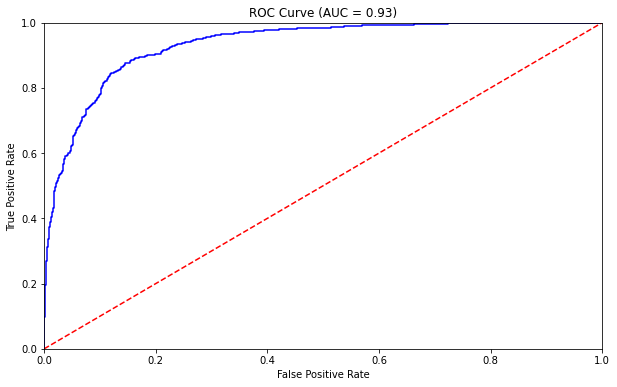

In [219]:
plt.figure(figsize = (10, 6))
plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

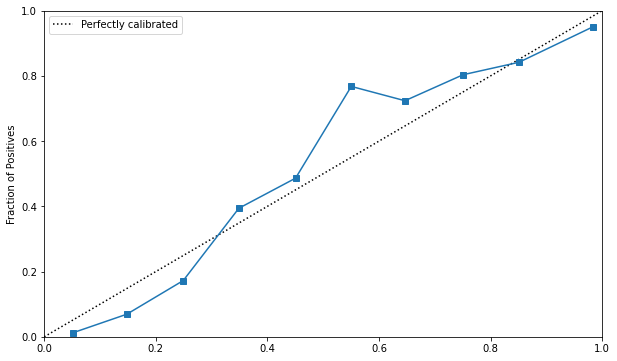

In [220]:
plt.figure(figsize = (10, 6))
fp_0, mpv_0 = calibration_curve(y_test, y_test_pred_probs, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

In [221]:
y_test_pred = best_model.predict(X_test)
print('***********************************************************************************')
print('Test Accuracy Score using L2 Logistic Regression:', accuracy_score(y_test_pred, y_test))
print('***********************************************************************************')

***********************************************************************************
Test Accuracy Score using L2 Logistic Regression: 0.8600337268128162
***********************************************************************************


### Model 2: SVM Model
In this model, the hyperparaters we tuned include:
1. penalty strength paramtera C
2. different kernel functions
3. the gamma parameter which decides the curvature of rbf methods for the decision boundary

In [209]:
svm_model = SVC(probability=True)
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid']}
cross_validation_model = GridSearchCV(svm_model,param_grid,refit=True,verbose=2)

start_timer = time.time()
cross_validation_model.fit(X_train,y_train)
end_timer = time.time()
best_model = cross_validation_model.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  51.5s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  54.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  52.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  51.7s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=  51.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 1.1min
[CV] END .......................C=0.1, gamma=0.

[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time= 1.3min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time= 1.3min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time= 1.4min
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time= 1.2min
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=  58.7s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=  58.9s
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time= 1.0min
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time= 1.0min
[CV] END ...................C=10, gamma=0.01, kernel=sigmoid; total time=  57.7s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=  48.8s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=  53.8s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=  48.9s
[CV] END ...................

In [211]:
best_params = cross_validation_model.best_params_
print("Total Time Spent for CV process: " + str(round(end_timer - start_timer, 2)) + " seconds")
print("Optimal parameters:", best_params)

Total Time Spent for CV process: 10278.02 seconds
Optimal parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [212]:
y_test_pred_probs = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)

y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

true_pos_train = tpr_train*(y_train.sum())
true_neg_train = (1 - fpr_train) *(1-y_train).sum()

highest_threshold_index = np.argmax(true_pos_train + true_neg_train)
highest_threshold = 1 if highest_threshold_index == 0 else thresholds_train[highest_threshold_index]

y_pred = (y_test_pred_probs > highest_threshold)

# len(y_pred)
print("*** Accuracy-maximizing threshold was: " + str(highest_threshold)+" ***")
print()
print("================Classification Report=================")
print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

*** Accuracy-maximizing threshold was: 0.476860966267463 ***

================Classification Report=================
              precision    recall  f1-score   support

  No default     0.7588    0.7351    0.7467      1087
     Default     0.7817    0.8023    0.7919      1285

    accuracy                         0.7715      2372
   macro avg     0.7702    0.7687    0.7693      2372
weighted avg     0.7712    0.7715    0.7712      2372



Text(0.5, 0, 'False Positive Rate')

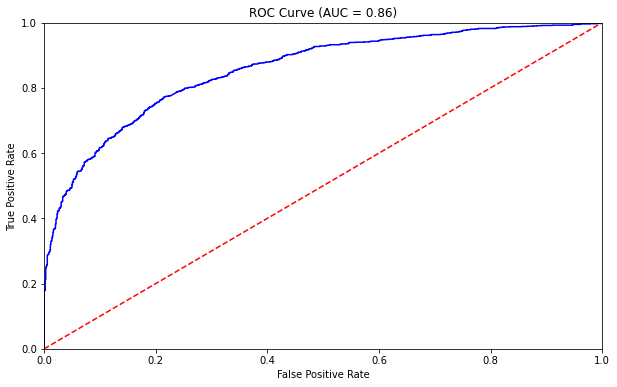

In [213]:
plt.figure(figsize = (10, 6))
plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

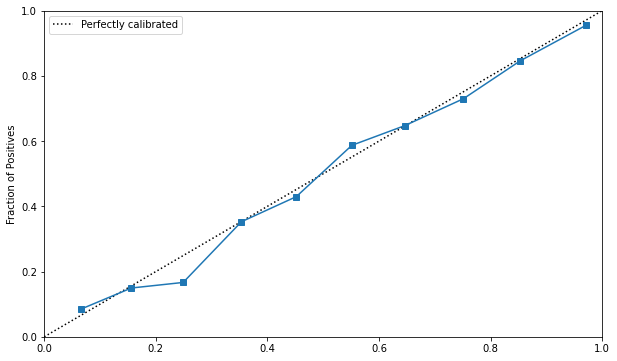

In [214]:
plt.figure(figsize = (10, 6))
fp_0, mpv_0 = calibration_curve(y_test, y_test_pred_probs, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

In [215]:
y_test_pred = best_model.predict(X_test)
print('***********************************************************************************')
print('Test Accuracy Score using SVM Model:', accuracy_score(y_test_pred, y_test))
print('***********************************************************************************')

***********************************************************************************
Test Accuracy Score using SVM Model: 0.7740303541315345
***********************************************************************************


### Model 3: Random Forest
In this model, the hyperparameters we tuned include:
1. *Min_Samples_leaf* which specifies the minimum number of data points we can have for each leaf node
2. *n_estimators* which specifies the total number of trees we have in the forest

In [222]:
random_forest = RandomForestClassifier()
param_grid = {'min_samples_leaf': np.arange(10, 70, step=10),
                 'n_estimators': [60,80, 100,120,150]}

cross_validation_model = GridSearchCV(random_forest,param_grid,refit=True,verbose=2)

start_timer = time.time()
cross_validation_model.fit(X_train,y_train)
end_timer = time.time()
best_model = cross_validation_model.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...............min_samples_leaf=10, n_estimators=60; total time=   0.5s
[CV] END ...............min_samples_leaf=10, n_estimators=60; total time=   0.5s
[CV] END ...............min_samples_leaf=10, n_estimators=60; total time=   0.5s
[CV] END ...............min_samples_leaf=10, n_estimators=60; total time=   0.5s
[CV] END ...............min_samples_leaf=10, n_estimators=60; total time=   0.5s
[CV] END ...............min_samples_leaf=10, n_estimators=80; total time=   0.6s
[CV] END ...............min_samples_leaf=10, n_estimators=80; total time=   0.6s
[CV] END ...............min_samples_leaf=10, n_estimators=80; total time=   0.6s
[CV] END ...............min_samples_leaf=10, n_estimators=80; total time=   0.6s
[CV] END ...............min_samples_leaf=10, n_estimators=80; total time=   0.7s
[CV] END ..............min_samples_leaf=10, n_estimators=100; total time=   0.8s
[CV] END ..............min_samples_leaf=10, n_e

[CV] END ...............min_samples_leaf=50, n_estimators=60; total time=   0.3s
[CV] END ...............min_samples_leaf=50, n_estimators=60; total time=   0.3s
[CV] END ...............min_samples_leaf=50, n_estimators=60; total time=   0.3s
[CV] END ...............min_samples_leaf=50, n_estimators=60; total time=   0.3s
[CV] END ...............min_samples_leaf=50, n_estimators=80; total time=   0.4s
[CV] END ...............min_samples_leaf=50, n_estimators=80; total time=   0.4s
[CV] END ...............min_samples_leaf=50, n_estimators=80; total time=   0.3s
[CV] END ...............min_samples_leaf=50, n_estimators=80; total time=   0.4s
[CV] END ...............min_samples_leaf=50, n_estimators=80; total time=   0.4s
[CV] END ..............min_samples_leaf=50, n_estimators=100; total time=   0.4s
[CV] END ..............min_samples_leaf=50, n_estimators=100; total time=   0.4s
[CV] END ..............min_samples_leaf=50, n_estimators=100; total time=   0.4s
[CV] END ..............min_s

In [223]:
best_params = cross_validation_model.best_params_
print("Total Time Spent for CV process: " + str(round(end_timer - start_timer, 2)) + " seconds")
print("Optimal parameters:", best_params)

Total Time Spent for CV process: 96.02 seconds
Optimal parameters: {'min_samples_leaf': 10, 'n_estimators': 60}


In [224]:
y_test_pred_probs = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)

y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

true_pos_train = tpr_train*(y_train.sum())
true_neg_train = (1 - fpr_train) *(1-y_train).sum()

highest_threshold_index = np.argmax(true_pos_train + true_neg_train)
highest_threshold = 1 if highest_threshold_index == 0 else thresholds_train[highest_threshold_index]

y_pred = (y_test_pred_probs > highest_threshold)

# len(y_pred)
print("*** Accuracy-maximizing threshold was: " + str(highest_threshold)+" ***")
print()
print("================Classification Report=================")
print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

*** Accuracy-maximizing threshold was: 0.40704145306719247 ***

================Classification Report=================
              precision    recall  f1-score   support

  No default     0.8716    0.7305    0.7948      1087
     Default     0.7995    0.9089    0.8507      1285

    accuracy                         0.8272      2372
   macro avg     0.8355    0.8197    0.8227      2372
weighted avg     0.8325    0.8272    0.8251      2372



Text(0.5, 0, 'False Positive Rate')

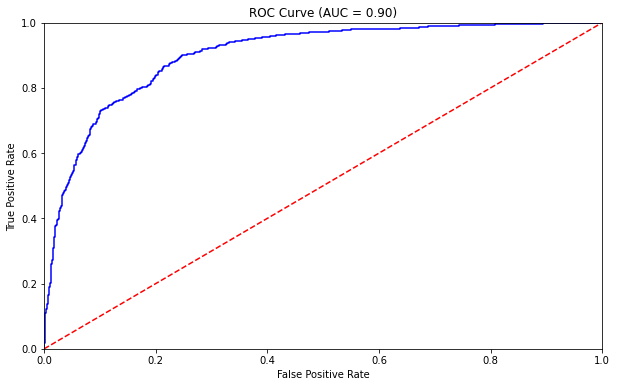

In [225]:
plt.figure(figsize = (10, 6))
plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

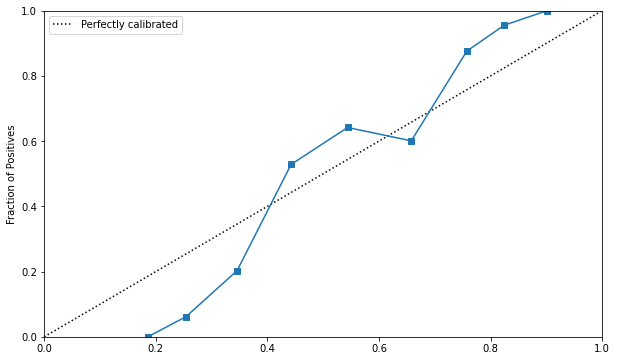

In [226]:
plt.figure(figsize = (10, 6))
fp_0, mpv_0 = calibration_curve(y_test, y_test_pred_probs, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

In [227]:
y_test_pred = best_model.predict(X_test)
print('***********************************************************************************')
print('Test Accuracy Score using Random Forest:', accuracy_score(y_test_pred, y_test))
print('***********************************************************************************')

***********************************************************************************
Test Accuracy Score using Random Forest: 0.8195615514333895
***********************************************************************************


### Model 4: Multilayer Perceptron

In [228]:
mlp = MLPClassifier(max_iter=10000)
param_grid = {'hidden_layer_sizes': [(10,),(30,),(50,),(100,),(10,10),(8,8),(5,5)],
                'learning_rate_init': [1e-2, 1e-3, 1e-4]}

cross_validation_model = GridSearchCV(mlp,param_grid,refit=True,verbose=2)

start_timer = time.time()
cross_validation_model.fit(X_train,y_train)
end_timer = time.time()
best_model = cross_validation_model.best_estimator_

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END ..hidden_layer_sizes=(10,), learning_rate_init=0.01; total time=   2.9s
[CV] END ..hidden_layer_sizes=(10,), learning_rate_init=0.01; total time=   0.8s
[CV] END ..hidden_layer_sizes=(10,), learning_rate_init=0.01; total time=   3.9s
[CV] END ..hidden_layer_sizes=(10,), learning_rate_init=0.01; total time=   3.2s
[CV] END ..hidden_layer_sizes=(10,), learning_rate_init=0.01; total time=   2.7s
[CV] END .hidden_layer_sizes=(10,), learning_rate_init=0.001; total time=   3.8s
[CV] END .hidden_layer_sizes=(10,), learning_rate_init=0.001; total time=   6.0s
[CV] END .hidden_layer_sizes=(10,), learning_rate_init=0.001; total time=   3.2s
[CV] END .hidden_layer_sizes=(10,), learning_rate_init=0.001; total time=   3.6s
[CV] END .hidden_layer_sizes=(10,), learning_rate_init=0.001; total time=   3.0s
[CV] END hidden_layer_sizes=(10,), learning_rate_init=0.0001; total time=  15.3s
[CV] END hidden_layer_sizes=(10,), learning_rat

[CV] END hidden_layer_sizes=(5, 5), learning_rate_init=0.0001; total time=  19.7s
[CV] END hidden_layer_sizes=(5, 5), learning_rate_init=0.0001; total time=  19.7s
[CV] END hidden_layer_sizes=(5, 5), learning_rate_init=0.0001; total time=  21.2s
[CV] END hidden_layer_sizes=(5, 5), learning_rate_init=0.0001; total time=  20.3s
[CV] END hidden_layer_sizes=(5, 5), learning_rate_init=0.0001; total time=  10.8s


In [229]:
best_params = cross_validation_model.best_params_
print("Total Time Spent for CV process: " + str(round(end_timer - start_timer, 2)) + " seconds")
print("Optimal parameters:", best_params)

Total Time Spent for CV process: 818.35 seconds
Optimal parameters: {'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.001}


In [230]:
y_test_pred_probs = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)

y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

true_pos_train = tpr_train*(y_train.sum())
true_neg_train = (1 - fpr_train) *(1-y_train).sum()

highest_threshold_index = np.argmax(true_pos_train + true_neg_train)
highest_threshold = 1 if highest_threshold_index == 0 else thresholds_train[highest_threshold_index]

y_pred = (y_test_pred_probs > highest_threshold)

# len(y_pred)
print("*** Accuracy-maximizing threshold was: " + str(highest_threshold)+" ***")
print()
print("================Classification Report=================")
print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

*** Accuracy-maximizing threshold was: 0.514226616643288 ***

================Classification Report=================
              precision    recall  f1-score   support

  No default     0.8678    0.8335    0.8503      1087
     Default     0.8637    0.8926    0.8779      1285

    accuracy                         0.8655      2372
   macro avg     0.8658    0.8630    0.8641      2372
weighted avg     0.8656    0.8655    0.8653      2372



Text(0.5, 0, 'False Positive Rate')

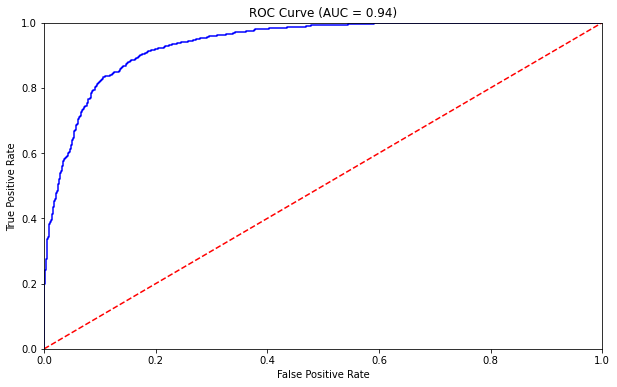

In [231]:
plt.figure(figsize = (10, 6))
plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_probs))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

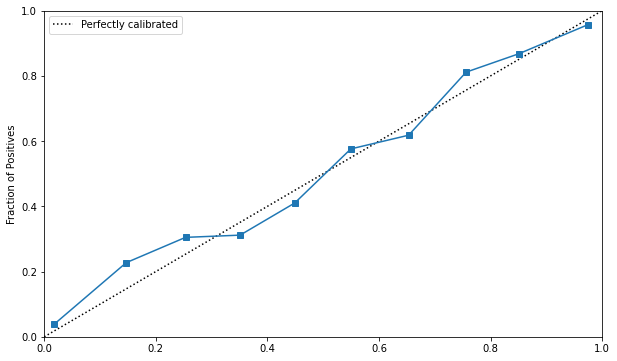

In [232]:
plt.figure(figsize = (10, 6))
fp_0, mpv_0 = calibration_curve(y_test, y_test_pred_probs, n_bins = 10)
plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
plt.plot(mpv_0, fp_0, 's-')
plt.ylabel('Fraction of Positives')
plt.xlim([0,1]); plt.ylim([0,1])
plt.legend(loc ='upper left')

In [233]:
y_test_pred = best_model.predict(X_test)
print('***********************************************************************************')
print('Test Accuracy Score using MLP:', accuracy_score(y_test_pred, y_test))
print('***********************************************************************************')

***********************************************************************************
Test Accuracy Score using MLP: 0.866779089376054
***********************************************************************************


### Result
 Model | Accuracy |
-------|----------|
 Logistic Regression |   0.8600337268128162  |
 Support Vector Machine |   0.7740303541315345  |
 Random Forest|   0.8195615514333895  |
 Multilayer Perceptron |   0.866779089376054  |

As the table shows above, the multilayer perceptron method, as we have expected, has the highest score around `0.8668` since this model can be generally applied to complex non-linear data. The performance of its calibration curve also delivers a good result as no noticeable deviation from the perfect calibration line exists. 

On the other hand, the Random Forest model has the poorest performance on the dataset of all. Given the highest time and computational resources the model has consumed and the lowest accuracy it achieved, we may make a generalized conclusion that the Random Forest model is not suitable to predict the match result for most of the MOBA games on the markets. It is also logically plausible for its unfit: in the multiplayer online battle games with high complexity, we should not treat each of the features/factors individually; either the method of bagged trees or random forest lies on the base of the decision tree, it might be convenient for implementation and interpretation, but the trade-off is that each of the features is not the best at its own job in determining the result of the game. 

## Top Feature Analysis

In order to help LoL players with their game performance, we explore the top features of winning a LoL match.

In [119]:
feature_importance = pd.DataFrame()
feature_importance['Feature'] = df_new.columns
feature_importance['Weights'] = l2_logistic.coef_[0].reshape(174,1)
feature_importance['Weights'] = feature_importance['Weights'].abs()

feature_without_champ_index = []
for i in range(174):
    if 'champ' not in feature_importance['Feature'][i]:
        feature_without_champ_index.append(i)
        
feature_importance_without_champ = feature_importance.iloc[feature_without_champ_index]
feature_importance_without_champ['Weights'] = feature_importance_without_champ['Weights'].abs()
feature_importance_without_champ.sort_values(by=['Weights'], ascending=False, inplace=True)

feature_champ_index = []
for i in range(174):
    if 'champ' in feature_importance['Feature'][i]:
        feature_champ_index.append(i)

feature_importance_for_champ = feature_importance.iloc[feature_champ_index]
feature_importance_for_champ['Weights'] = feature_importance_for_champ['Weights'].abs()
feature_importance_for_champ.sort_values(by=['Weights'], ascending=False, inplace=True)
# feature_importance_for_champ

<ipython-input-119-37c959edb8be>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance_without_champ['Weights'] = feature_importance_without_champ['Weights'].abs()
<ipython-input-119-37c959edb8be>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance_without_champ.sort_values(by=['Weights'], ascending=False, inplace=True)
<ipython-input-119-37c959edb8be>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

### Top Champions

In [122]:
feature_importance_for_champ

,Feature,Weights
90,champ_Nautilus,0.025341
58,champ_Jhin,0.016596
12,champ_Ahri,0.013517
52,champ_Irelia,0.013288
74,champ_Lee Sin,0.012762
...,...,...
95,champ_Oalf,0.000109
162,champ_Zac,0.000105
135,champ_Thresh,0.000091
34,champ_Dr.Mundo,0.000082


Text(0, 0.5, 'Champions')

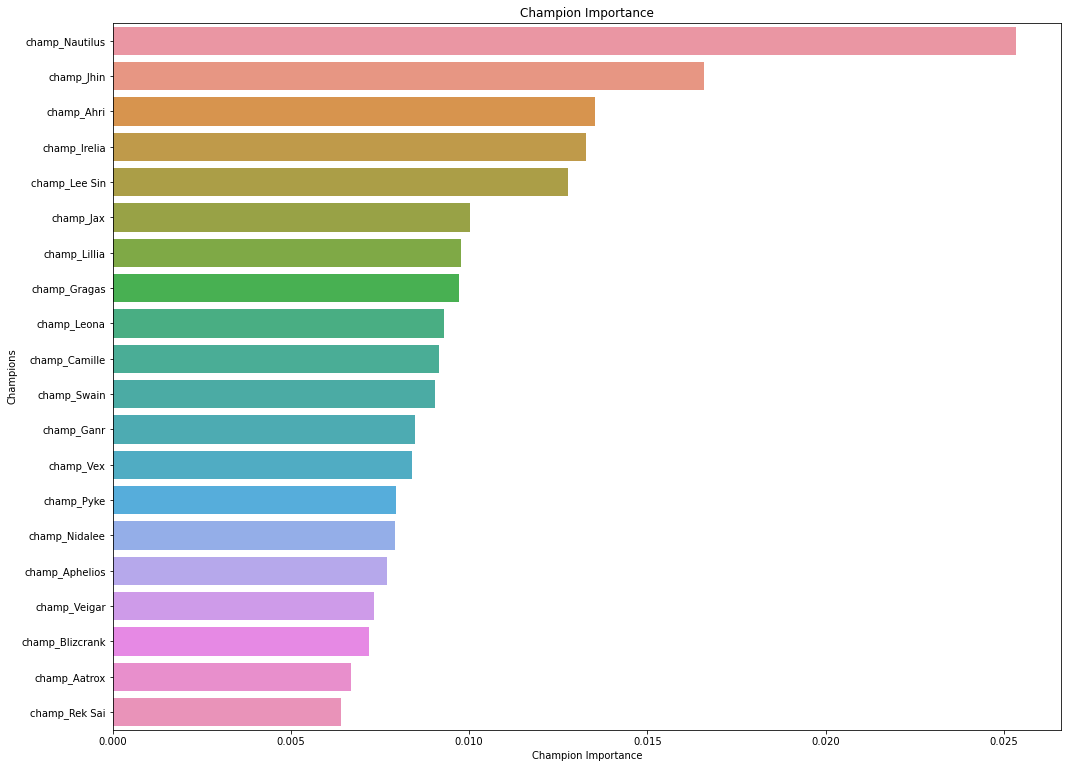

In [123]:
feature_importance.sort_values(by=['Weights'], ascending=False, inplace =True)

plt.figure(figsize=(17,13))
sns.barplot(x=feature_importance_for_champ['Weights'][:20], y=feature_importance_for_champ['Feature'][:20])
plt.title('Champion Importance')
plt.xlabel('Champion Importance')
plt.ylabel('Champions')

### Champion Suggestions and Insights

 Based on the top champions analysis above, we can tell that champions such as `Nautilus`, `Jhin`, and `Ahri` have the highest weights. It means that they play a crucial role in contributing to the victory of their game. Our suggestion for players, therefore, is to improve their proficiency on those champions and try to pick them whenever those champions can fit into the composition of the entire team.

Besides suggestions for gameplay, we can also draw some helpful insights: Most of the champions on the Top feature rank are the functional champions, which are the type of champions that mainly focus on benefiting teammates(the assistants) rather than doing greater damage to the enemy. Therefore, we can know that instead of letting individual players who outplayed others project a more significant influence on the result of the game, LOL company has pivoted the game-playing style to have a heavy focus on the team collaborations in the current version. That is a great indication telling us that, in order to have a greater chance of winning, we should pay more attention to teammates' actions and try to help them whenever there is a chance.

### Top Features

In [124]:
feature_importance_without_champ

,Feature,Weights
10,kda,1.325720
7,mvpScore,0.281339
3,team,0.141328
1,hotStreak,0.099872
0,winRate,0.095425
173,role_TOP,0.094802
6,kp,0.077696
172,role_SUPPORT,0.068868
9,sightWardsPlaced,0.054180
171,role_MID,0.047332


Text(0, 0.5, 'Features')

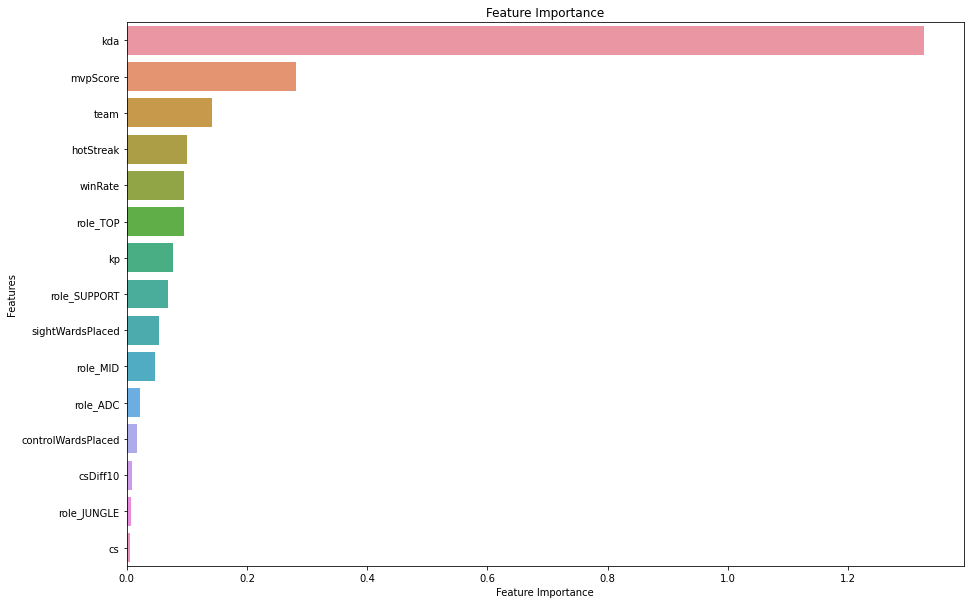

In [126]:
plt.figure(figsize=(15,10))
sns.barplot(x=feature_importance_without_champ['Weights'], y=feature_importance_without_champ['Feature'])
plt.title('Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')

### Gameplay Suggestions

Here, we remove all the champions from the feature analysis so that we can find out other factors that have a significant influence on the match outcome besides champion selection. We now draw some new insights from the graph above. For example, the feature 'role_Top' has a relatively high weight, which tells us that the Top position in a team plays a much more important role in the current version of the game. To elaborate a bit on this, it makes sense that TOp nowadays are the main driving forces that help to mobilize the rest of the team in either situation where they choose to split push or initiate a attack in late games.

# Conclusion

In this data science task, we have successfully make prediction for the game match of League of Legends. With the model we have built, players are able to predict the chance of winning based their recent performances and character selection and the accuracy has reach more than 88%. By listing multiple combinations of  input and outcome, players are able to learning their strength and weakness in terms of gaming skills and strategy planning.

In addition ,we also conduct a Top feature analysis based different tiers to provide suggestions on which of the dimensions or skills players can focus on for improvement. We believe this function would successfully alight the vision of our project, which is helpings players to improve skills and enjoy the overall gaming experience.

### Improvement & Further Steps
We believe that the amount of information and number of features could still be expanded. Although we have utilized many tools such as API, scrapping as well as other libraries to collect data, there still are many significant factors that have been missed, for example, the average number of dragons has been killed by the players and the average number of times players has taken crowd control, these all are very important features that can reflect the play-style and measures their performances. In addition, we will try to expand the scope of regions in which top players locate so that we can minimize the bias(caused by geographic factors) as much as possible

To take one step further, we want to explore the possibility of implementing an unsupervised learning model on our datasets such as K-means and hierarchical Clusterings.

Thanks for reading!